In [40]:
# data processing
import pandas as pd
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# modelling sklearn
from sklearn.metrics import classification_report, auc, confusion_matrix, accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import json

In [41]:
mnist = keras.datasets.mnist
anomalies = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Dataset split: 60000 train rows
Dataset split: 10000 test rows


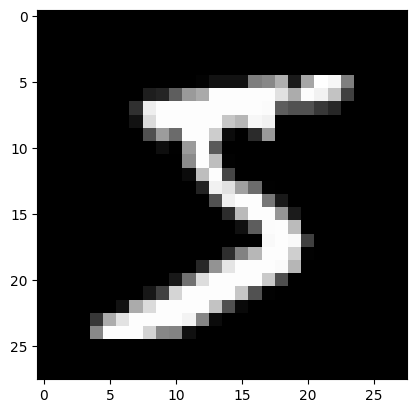

In [42]:
print(f"Dataset split: {len(x_train)} train rows")
print(f"Dataset split: {len(x_test)} test rows")

point = x_train[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [43]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [44]:
# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape the data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [45]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [46]:
# Input image
input_img = Input(shape=(784,))

In [47]:
# encoder
encoded = Dense(256, activation='relu')(input_img)
encoded = Dropout(0.5)(encoded)
encoded = ReLU(0.5)(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)
encoded = ReLU(0.5)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)
encoded = ReLU(0.5)(encoded)
encoded = Dense(32, activation='relu')(encoded)

In [48]:
# decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dropout(0.5)(decoded)
encoded = ReLU(0.5)(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dropout(0.5)(decoded)
encoded = ReLU(0.5)(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dropout(0.5)(decoded)
encoded = ReLU(0.5)(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [49]:
autoencoder = Model(input_img, decoded)

In [50]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [51]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=64, shuffle=True,
                          validation_data=(x_test, x_test), callbacks=[early_stopping])

Epoch 1/100


938/938 [==============================] - 6s 5ms/step - loss: 0.0677 - val_loss: 0.0583
Epoch 2/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0577 - val_loss: 0.0544
Epoch 3/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0551 - val_loss: 0.0523
Epoch 4/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0536 - val_loss: 0.0512
Epoch 5/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0528 - val_loss: 0.0502
Epoch 6/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0521 - val_loss: 0.0492
Epoch 7/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0515 - val_loss: 0.0485
Epoch 8/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0509 - val_loss: 0.0475
Epoch 9/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0503 - val_loss: 0.0469
Epoch 10/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0499 - val_loss: 0.0468
E

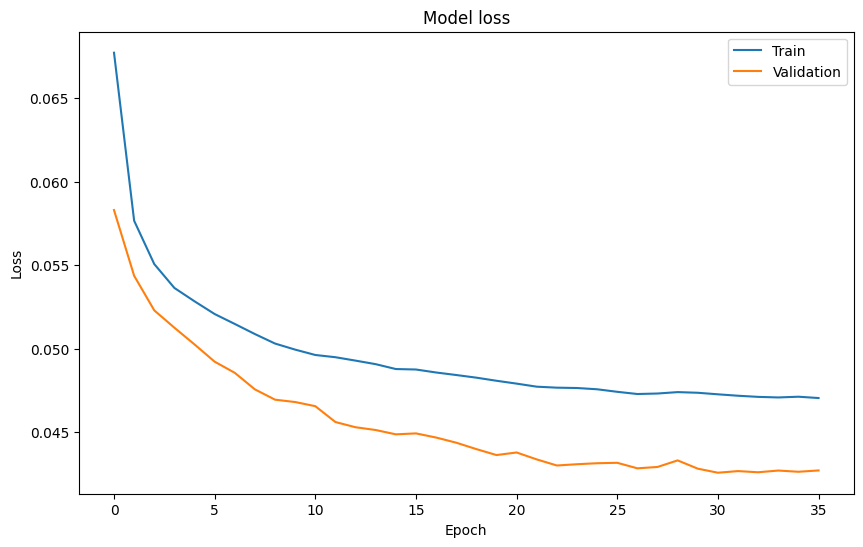

In [52]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [53]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 0s 1ms/step


In [54]:
reconstruction_errors = np.mean(np.square(x_test - decoded_imgs), axis=1)

In [55]:
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies based on the threshold
anomaly_indexes = np.where(reconstruction_errors > threshold)[0]

In [56]:
# Classify anomalies based on the threshold
predictions = (reconstruction_errors > threshold).astype(int)

In [57]:
# Get corresponding labels for anomaly indexes
anomaly_labels = [y_test[i] for i in anomaly_indexes]

# Print or use anomaly_indexes and anomaly_labels as needed
print("Anomaly Indexes:", anomaly_indexes)
print("Anomaly Labels:", anomaly_labels)

Anomaly Indexes: [   8   18   33   48   54   72  126  151  200  222  225  287  305  311
  338  352  360  362  372  380  421  437  445  475  490  495  514  549
  625  631  642  654  655  710  720  744  787  792  804  810  864  876
  877  894  896  923  985  998 1017 1032 1050 1052 1060 1101 1102 1128
 1143 1170 1263 1272 1319 1325 1348 1352 1377 1391 1444 1463 1468 1525
 1526 1529 1530 1556 1567 1601 1609 1610 1618 1627 1641 1671 1712 1720
 1727 1737 1748 1749 1758 1775 1782 1790 1801 1841 1859 1882 1895 1987
 2044 2057 2060 2107 2110 2115 2118 2145 2186 2215 2224 2229 2237 2253
 2272 2291 2293 2299 2319 2326 2351 2378 2408 2436 2462 2470 2476 2479
 2515 2589 2653 2664 2684 2686 2695 2728 2747 2749 2756 2770 2773 2797
 2802 2830 2882 2894 2896 2927 2959 2990 3011 3016 3021 3031 3037 3069
 3120 3170 3198 3251 3260 3263 3269 3289 3290 3295 3311 3329 3348 3364
 3394 3412 3441 3447 3488 3517 3521 3525 3534 3540 3542 3575 3681 3705
 3710 3727 3744 3752 3768 3772 3778 3799 3801 3803 3813 3817

In [58]:
# Get all the anomalies from the test_images
anomalies = x_test[anomaly_indexes]

print(len(anomalies))

500


In [59]:
# Get anomaly labels
anomaly_indexes = np.array(anomaly_indexes, dtype=int)
label_of_anomalies = [y_test[i] for i in anomaly_indexes]

# create a dict of indexes and labels
anomaly_dict = dict(zip(map(int, anomaly_indexes), label_of_anomalies))

In [60]:
anomaly_dict_serializable = {int(key): str(value) for key, value in anomaly_dict.items()}

In [61]:
# write to json file
json_filename = "anomalies.json"
with open(json_filename, 'w') as json_file:
    json.dump(anomaly_dict_serializable, json_file)

print(f"Anomaly dictionary saved to {json_filename}")

Anomaly dictionary saved to anomalies.json


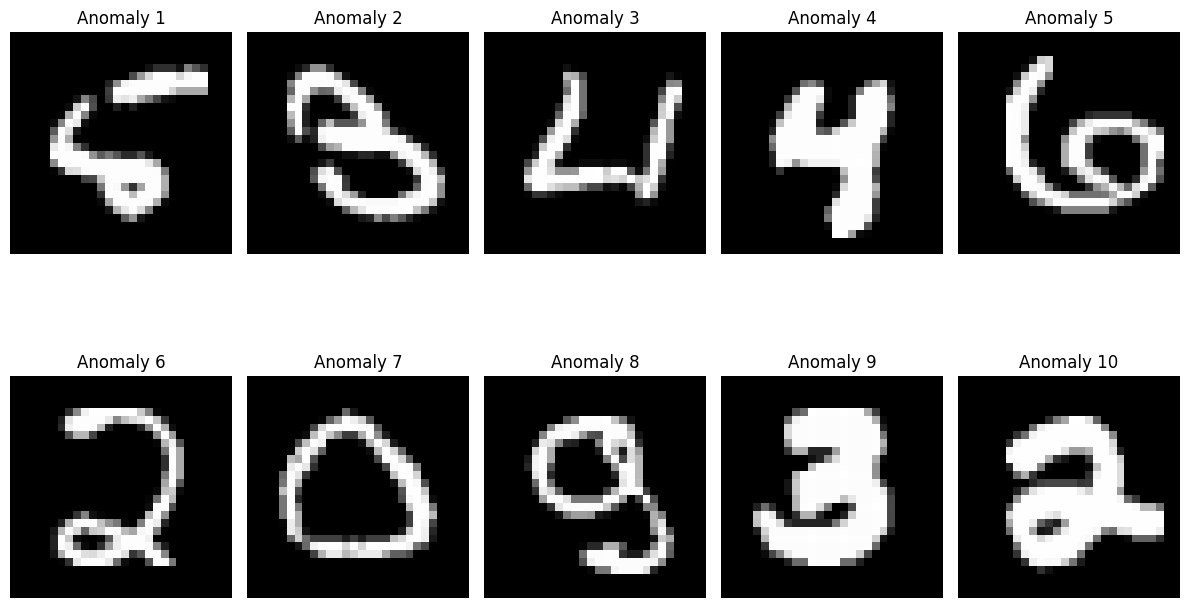

In [62]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomaly indices
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


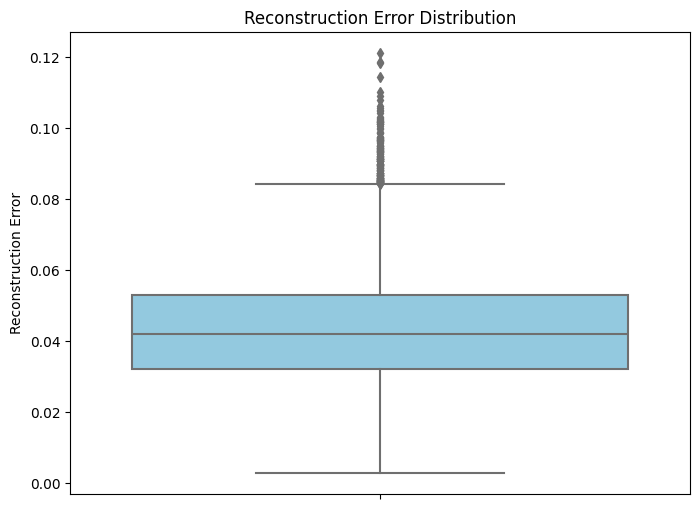

In [63]:
# Plot a boxplot of the reconstruction errors
plt.figure(figsize=(8, 6))
sns.boxplot(y=reconstruction_errors, color='skyblue')
plt.title('Reconstruction Error Distribution')
plt.ylabel('Reconstruction Error')
plt.show()

C:\Users\zippe\AppData\Local\Temp\ipykernel_12756\2073315374.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, c=['red' if e > threshold else 'blue' for e in reconstruction_errors], cmap='coolwarm', marker='o', edgecolors='k')


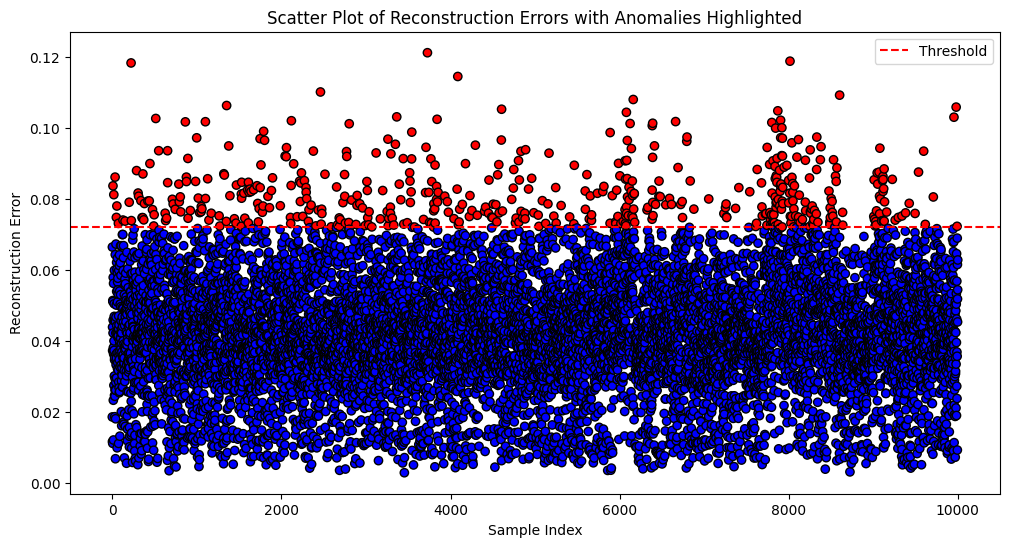

In [64]:
# Create a binary array indicating anomalies
anomaly_indicator = np.where(reconstruction_errors > threshold, 1, 0)

# Create a scatter plot of reconstruction errors with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, c=['red' if e > threshold else 'blue' for e in reconstruction_errors], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors with Anomalies Highlighted')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

In [65]:
# Map the class labels to "anomaly" and "normal"
class_labels = {0: 'normal', 1: 'anomaly'}
predictions_mapped = np.vectorize(class_labels.get)(predictions)
y_test_mapped = np.vectorize(class_labels.get)(y_test)

In [66]:
# Ensure that y_test_mapped and predictions_mapped are binary (0 or 1)
y_test_mapped_binary = np.where(y_test_mapped == 'anomaly', 1, 0)
predictions_mapped_binary = np.where(predictions_mapped == 'anomaly', 1, 0)

In [67]:
# Evaluate performance metrics
accuracy = accuracy_score(y_test_mapped_binary, predictions_mapped_binary)
precision = precision_score(y_test_mapped_binary, predictions_mapped_binary)
recall = recall_score(y_test_mapped_binary, predictions_mapped_binary)
f1 = f1_score(y_test_mapped_binary, predictions_mapped_binary)

In [68]:
# Print and display the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8365
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


In [69]:
report = classification_report(y_test_mapped_binary, predictions_mapped_binary, target_names=['normal', 'anomaly'])

# Print or use the classification report as needed
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      normal       0.88      0.94      0.91      8865
     anomaly       0.00      0.00      0.00      1135

    accuracy                           0.84     10000
   macro avg       0.44      0.47      0.46     10000
weighted avg       0.78      0.84      0.81     10000



In [70]:
# calculate the precision and recall for different threshold levels
precision_curve, recall_curve, _ = precision_recall_curve(y_test_mapped_binary, reconstruction_errors)

# calculate the area under the precision-recall curve
pr_auc = auc(recall_curve, precision_curve)

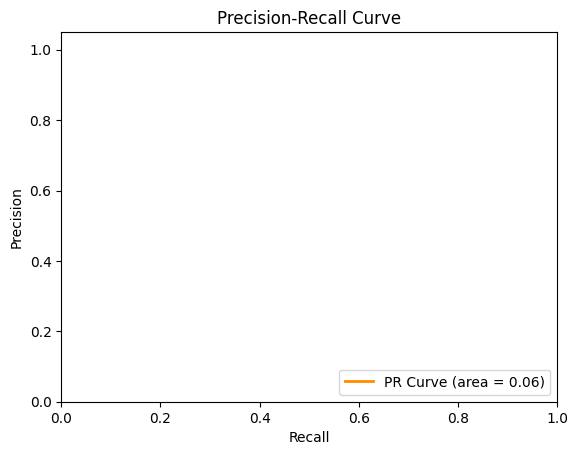

In [71]:
# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR Curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

In [72]:
# ROC Curve and ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test_mapped_binary, reconstruction_errors)
roc_auc = roc_auc_score(y_test_mapped_binary, reconstruction_errors)

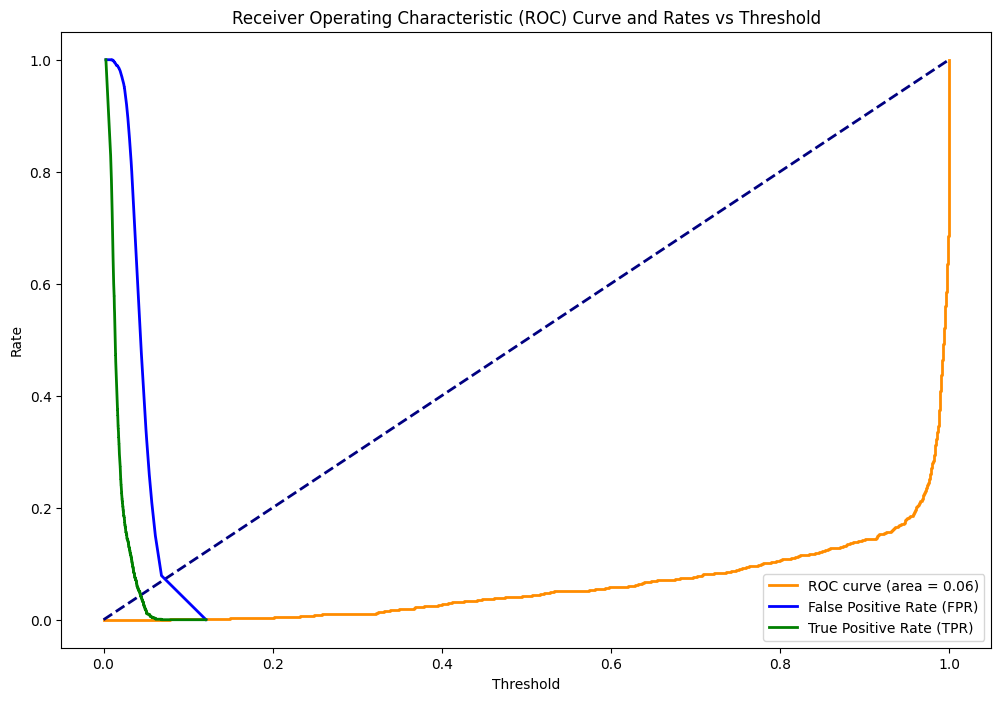

In [73]:
# Plot ROC curve, FPR vs TPR, and True Positive Rate vs Threshold in a single plot
plt.figure(figsize=(12, 8))

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Plot False Positive Rate vs Threshold
plt.plot(thresholds, fpr, color='blue', lw=2, label='False Positive Rate (FPR)')

# Plot True Positive Rate vs Threshold
plt.plot(thresholds, tpr, color='green', lw=2, label='True Positive Rate (TPR)')

# Set labels and title
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve and Rates vs Threshold')
plt.legend(loc='lower right')

# Show the combined plot
plt.show()

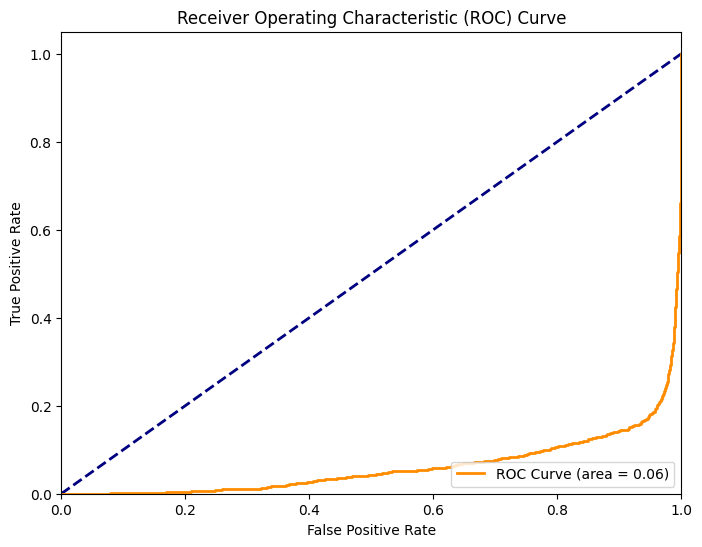

In [74]:
# Plot ROC-AUC
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [75]:
conf_matrix = confusion_matrix(y_test_mapped_binary, predictions_mapped_binary)

In [76]:
print(conf_matrix)

[[8365  500]
 [1135    0]]


In [77]:
tn, fp, fn, tp = conf_matrix.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 8365
False Positives: 500
False Negatives: 1135
True Positives: 0
